In [48]:
import pandas as pd
import numpy as np
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Definition der Dataframes:

In [49]:
df_walk = pd.read_json("normal_walk.json")

df_fall = pd.read_json("fall.json")

df_testFall = pd.read_json("test_fall.json")

In [50]:
df_walk.describe()

,time,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.560600e+04,1.560600e+04,15605.000000,15605.000000,15605.000000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.683269e+18,-6.919721e+02,0.051799,0.440262,0.023489,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4.567039e+13,4.567039e+04,0.567014,1.009353,0.893979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.680417e+18,-2.852898e+06,-5.566208,-5.664675,-4.368199,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.683270e+18,1.962529e+01,-0.221366,-0.224200,-0.224045,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.683270e+18,3.925919e+01,0.022858,0.793248,0.062439,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.683270e+18,5.889272e+01,0.314255,1.077164,0.407181,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.683270e+18,7.852227e+01,4.551981,5.324697,4.855778,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

In [52]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,Accelerometer,2023-04-02 06:30:19.905724160,-2.852898e+06,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibrated,2023-05-05 06:58:38.144353792,1.635376e-02,-0.770004,-0.392059,0.095901,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibrated,2023-05-05 06:58:38.154418944,2.641895e-02,-0.801300,-0.401917,0.068222,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibrated,2023-05-05 06:58:38.164484096,3.648413e-02,-0.832657,-0.412109,0.057846,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibrated,2023-05-05 06:58:38.174548992,4.654907e-02,-0.863892,-0.420822,0.063507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
df_testFall = df_testFall.set_index('time')

In [54]:
df_walk['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

In [55]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']

df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

In [56]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]

df_testFall_acc = df_testFall_acc[['z','x','y']]

<AxesSubplot:xlabel='time'>

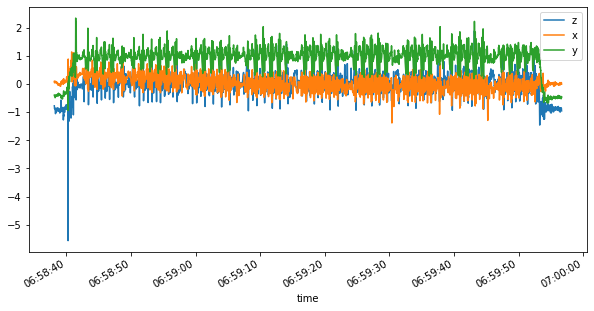

In [57]:
df_walk_acc.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

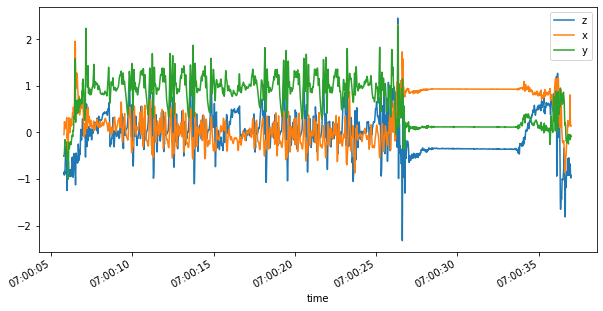

In [58]:
df_fall_acc.plot(figsize=(10,5))

<AxesSubplot:xlabel='time'>

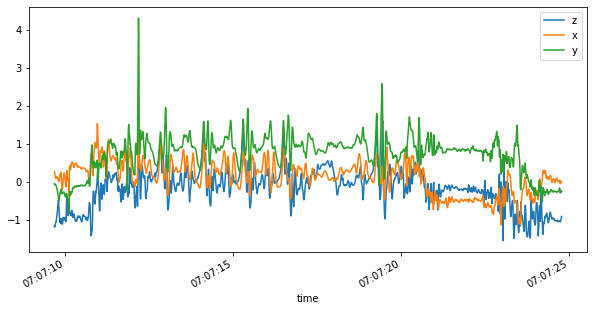

In [59]:
df_testFall_acc.plot(figsize=(10,5))

Create Training Data

In [60]:
df_walk_acc['label'] = "walk"
df_fall_acc['label'] = "fall"

df_testFall_acc['label'] = "fall"

df_combined = pd.concat([df_walk_acc, df_fall_acc])

In [61]:
#Anzahl der Reihen RowCount
len(df_walk_acc)
#Label hinzufügen

display(df_combined)

,z,x,y,label
time,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,walk
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,walk
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,walk
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,walk
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,walk
...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,fall
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,fall
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,fall


In [62]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df_combined):
    X_train, X_test = df_combined.iloc[train_index][['z','y','x']], df_combined.iloc[test_index][['z','y','x']]
    y_train, y_test = df_combined.iloc[train_index]["label"], df_combined.iloc[test_index]["label"]

    # Skalieren 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Passe Klassifikator an
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    # Evaluieren die Leistung des Klassifikators
    y_pred = clf.predict(X_test)
    #print(clf.predict(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.29334067143643366
Accuracy: 0.02531645569620253


In [63]:
df_testFall_acc.head()

,z,x,y,label
time,,,,
2023-05-05 07:07:09.681482752,-1.156128,0.280060,-0.049332,fall
2023-05-05 07:07:09.691546880,-1.181564,0.249557,-0.037933,fall
2023-05-05 07:07:09.701610752,-1.159286,0.184860,-0.051285,fall
2023-05-05 07:07:09.711674880,-1.104019,0.131989,-0.072357,fall
2023-05-05 07:07:09.721737984,-1.056854,0.102814,-0.069427,fall


In [64]:
df_testFall_acc.describe()

,z,x,y
count,1501.000000,1501.000000,1501.000000
mean,-0.150339,0.137636,0.738855
std,0.496869,0.414868,0.498444
min,-1.537582,-1.123581,-0.813660
25%,-0.392334,-0.113159,0.532272
50%,-0.101776,0.188156,0.845291
75%,0.166306,0.404861,0.998993
max,1.614059,1.538834,4.314255


In [65]:
#Test via Konfusionsmatrix
y_pred = clf.predict(X_test)
accuracy = sk.metrics.confusion_matrix(y_test, y_pred)
print(accuracy)

[[  46 1771]
 [   0    0]]


Alternative Herangehensweise an die Erstellung von TestDaten: 
######################### Siehe Übung ######################### Code auf unser Beispiel anzupassen

In [128]:
import random

walk = df_walk_acc[['z','y','x']].values
fall = df_fall_acc[['z','y','x']].values

training_data = []
label_data = []

for x in range(20):
    start = random.randint(0, len(walk)-31)
    end = start + 30
    training_data.append(walk[start:end].flatten())
    label_data.append("walk")
    
    
for x in range(20):
    start = random.randint(0, len(fall)-31)
    end = start + 30
    training_data.append(fall[start:end].flatten())
    label_data.append("fall")

In [129]:
training_data

[array([-1.20002747, -0.2875824 ,  0.13970947, -1.12969971, -0.26177979,
         0.17349243, -1.08837891, -0.24201965,  0.19464111, -1.11418152,
        -0.24176025,  0.19366455, -1.1399231 , -0.26438904,  0.16497803,
        -1.11395264, -0.30201721,  0.12939453, -1.03916931, -0.35044861,
         0.1000824 , -0.96061707, -0.39178467,  0.09310913, -0.90782166,
        -0.41925049,  0.1055603 , -0.87916565, -0.42843628,  0.11364746,
        -0.86784363, -0.42332458,  0.11268616, -0.87086487, -0.41419983,
         0.10409546, -0.88798523, -0.40348816,  0.09312439, -0.91574097,
        -0.39358521,  0.07879639, -0.95100403, -0.38806152,  0.06278992,
        -0.98323059, -0.387146  ,  0.04833984, -0.998703  , -0.38624573,
         0.03567505, -1.00402832, -0.37162781,  0.03686523, -0.99232483,
        -0.3624115 ,  0.04823303, -0.97224426, -0.35679626,  0.05337524,
        -0.95031738, -0.35876465,  0.05493164, -0.91712952, -0.36346436,
         0.05183411, -0.87252808, -0.36047363,  0.0

In [130]:
# Train
clf = RandomForestClassifier(random_state=0)
clf.fit(training_data, label_data)

RandomForestClassifier(random_state=0)

In [134]:
test = df_testFall_acc[['z','y','x']].values

i = random.randint(0, len(test)-1)

test_data = test[i]

print("real Label:", df_testFall_acc['label'][i])

clf.predict([test_data])


real Label: fall


ValueError: Number of features of the model must match the input. Model n_features is 90 and input n_features is 3 

In [99]:
# FOR EDUCATIONAL PURPOSES ONLY: NEVER EVER USE TRAINING DATA FOR TESTING

for x in range(100):
    i = random.randint(0, len(test)-1)
    test = test[i]
    label = "fall"
    prediction = clf.predict([test])[0]
    
    if label != prediction:
        print(f"Label: {label}, Prediction: {prediction}")


Label: fall, Prediction: walk


ValueError: Expected 2D array, got 1D array instead:
array=[0.01271057].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.